# 0. Imports

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import lightgbm

from os import cpu_count

# custom modules
from code.util import *
from code.preprocessor import *
from code.modelhelper import *

# set number of processes
N_JOBS = cpu_count() // 2
# N_JOBS = 1

---

In [2]:
data = load("data/urls_sampled.pkl")

# 1. Train/Test Split

In [3]:
x, y = data.url, data.target
x_train0, x_test0, y_train, y_test = train_test_split(x, y, 
                                                test_size=0.33, random_state=42)

# 2. Vectorization

In [4]:
stop_words = [
    "http",
    "https",
    "www",
    "com",
    "co",
]

vect = CountVectorizer(
    tokenizer=tokenize,
    stop_words=stop_words,
    max_features=6000
)

In [5]:
# vect = TfidfVectorizer(
#     tokenizer=tokenize,
#     max_df=0.9999,
#     min_df=0.0001,
#     max_features=3000
# )

In [6]:
vect.fit(x_train0)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=6000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['http', 'https', 'www', 'com', 'co'],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x131b1b9e0>, vocabulary=None)

In [7]:
x_train = vect.transform(x_train0).toarray()
x_test = vect.transform(x_test0).toarray()

# 3. Models

In [8]:
scores_dict = {}

## 3.1 Multinomial Naive Bayes

In [9]:
multnb = MultinomialNB()

In [10]:
cv_scores = workflow(multnb, "MultinomialNB", "recall",
                     x_train, x_test, y_train, y_test, N_JOBS)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

MODEL: MultinomialNB
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     34753
           1       0.94      0.81      0.87      7251

    accuracy                           0.96     42004
   macro avg       0.95      0.90      0.92     42004
weighted avg       0.96      0.96      0.96     42004

Cross validation score: 0.8154 (+/- 0.0071) [recall / MultinomialNB]

Elapsed time: 150.03s [fit 7.45s, predict 2.15s, cv: 140.43s]


In [10]:
scores_dict["MultinomialNB"] = cv_scores

In [11]:
save(multnb, "models/multnp.pkl")

## 3.2 Decision Tree

In [12]:
tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    random_state=42
)

In [13]:
cv_scores = workflow(tree, "DecisionTreeClassifier", "recall",
                     x_train, x_test, y_train, y_test, N_JOBS)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

MODEL: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     17271
           1       0.97      0.59      0.73      5067

    accuracy                           0.90     22338
   macro avg       0.93      0.79      0.84     22338
weighted avg       0.91      0.90      0.89     22338

Cross validation score: 0.90 (+/- 0.0041) [DecisionTreeClassifier]


In [14]:
scores_dict["DecisionTreeClassifier"] = cv_scores

In [15]:
save(tree, "models/tree.pkl")

## 3.3 Random Forest

In [16]:
forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=N_JOBS
)

In [18]:
cv_scores = workflow(forest, "RandomForestClassifier", "recall",
                     x_train, x_test, y_train, y_test, N_JOBS)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

MODEL: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     17271
           1       1.00      0.29      0.45      5067

    accuracy                           0.84     22338
   macro avg       0.91      0.65      0.68     22338
weighted avg       0.87      0.84      0.80     22338

Cross validation score: 0.84 (+/- 0.0039) [RandomForestClassifier]


In [19]:
scores_dict["RandomForestClassifier"] = cv_scores

In [20]:
save(forest, "models/forest.pkl")

## 3.4 Gradient Boosting (w/ LightGBM)

In [11]:
lgbm = lightgbm.LGBMClassifier(
    n_estimators=1000,
    max_depth=-1,
    objective="binary",
    n_jobs=N_JOBS,
    random_state=42
)

In [12]:
cv_scores = workflow(lgbm, "LGBMClassifier", "recall",
                     x_train, x_test, y_train, y_test, N_JOBS)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=6, num_leaves=31, objective='binary',
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

MODEL: LGBMClassifier
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17271
           1       0.95      0.88      0.92      5067

    accuracy                           0.96     22338
   macro avg       0.96      0.94      0.95     22338
weighted avg       0.96      0.96      0.96     22338

Cross validation score: 0.8861 (+/- 0.0100) [recall / LGBMClassifier]

Elapsed time: 71.92s [fit 5.08s, predict 0.95s, cv: 65.89s]


In [23]:
scores_dict["LGBMClassifier"] = cv_scores

In [24]:
save(lgbm, "models/lgbm.pkl")

## 3.5 Logistic Regression

In [25]:
logireg = LogisticRegression(n_jobs=N_JOBS)

In [26]:
cv_scores = workflow(logireg, "LogisticRegression", "recall",
                     x_train, x_test, y_train, y_test, N_JOBS)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=6, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

MODEL: LogisticRegression
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17271
           1       0.98      0.86      0.92      5067

    accuracy                           0.96     22338
   macro avg       0.97      0.93      0.95     22338
weighted avg       0.97      0.96      0.96     22338

Cross validation score: 0.96 (+/- 0.0025) [LogisticRegression]


In [27]:
scores_dict["LogisticRegression"] = cv_scores

In [28]:
save(logireg, "models/logireg.pkl")

## 3.6 Voting Classifier
Ensemble of the three best performing models

In [11]:
model1 = MultinomialNB(
    alpha=0.1
)

model2 = lightgbm.LGBMClassifier(
    n_estimators=1000,
    max_depth=-1,
    n_jobs=N_JOBS,
    random_state=42
)

model3 = LogisticRegression(n_jobs=N_JOBS)

voting = VotingClassifier(
    estimators=[
        ("mnb", model1),
        ("lgbm", model2),
        ("logi", model3)
    ],
    voting="soft",
    n_jobs=N_JOBS
)

In [12]:
cv_scores = workflow(voting, "VotingClassifier", "accuracy",
                     x_train, x_test, y_train, y_test, N_JOBS)

VotingClassifier(estimators=[('mnb',
                              MultinomialNB(alpha=0.1, class_prior=None,
                                            fit_prior=True)),
                             ('lgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=1500, n_jobs=6,
                                             num_leaves=31, objective=None...
                                             subsample=1.0,
                               

In [13]:
scores_dict["VotingClassifier"] = cv_scores

In [34]:
save(voting, "models/voting.pkl")

In [40]:
save(scores_dict, "data/cv_scores.pkl")

# 4. Performance Evaluation

In [41]:
scores_dict = load("data/cv_scores.pkl")

In [35]:
models = {
    "MultinomialNB": multnb,
    "DecisionTreeClassifier": tree,
    "RandomForestClassifier": forest,
    "LGBMClassifier": lgbm,
    "LogisticRegression": logireg,
    "VotingClassifier": voting
}

## 4.1 Average Cross Validation Accuracy

In [44]:
print("--- Mean Accuracy ---")
for name, score in scores_dict.items():
    print("{}: ".format(name) + "%0.4f"%(score.mean()))

--- Mean Accuracy ---
MultinomialNB: 0.9591
DecisionTreeClassifier: 0.9043
RandomForestClassifier: 0.8437
LGBMClassifier: 0.9553
LogisticRegression: 0.9640
VotingClassifier: 0.9647


In [46]:
data = [
    scores_dict["RandomForestClassifier"],
    scores_dict["DecisionTreeClassifier"],
    scores_dict["LGBMClassifier"],
    scores_dict["MultinomialNB"],
    scores_dict["LogisticRegression"],
    scores_dict["VotingClassifier"],
]

labels = [
    "RandomForestClassifier",
    "DecisionTreeClassifier",
    "LGBMClassifier",
    "MultinomialNB",
    "LogisticRegression",
    "VotingClassifier",
]

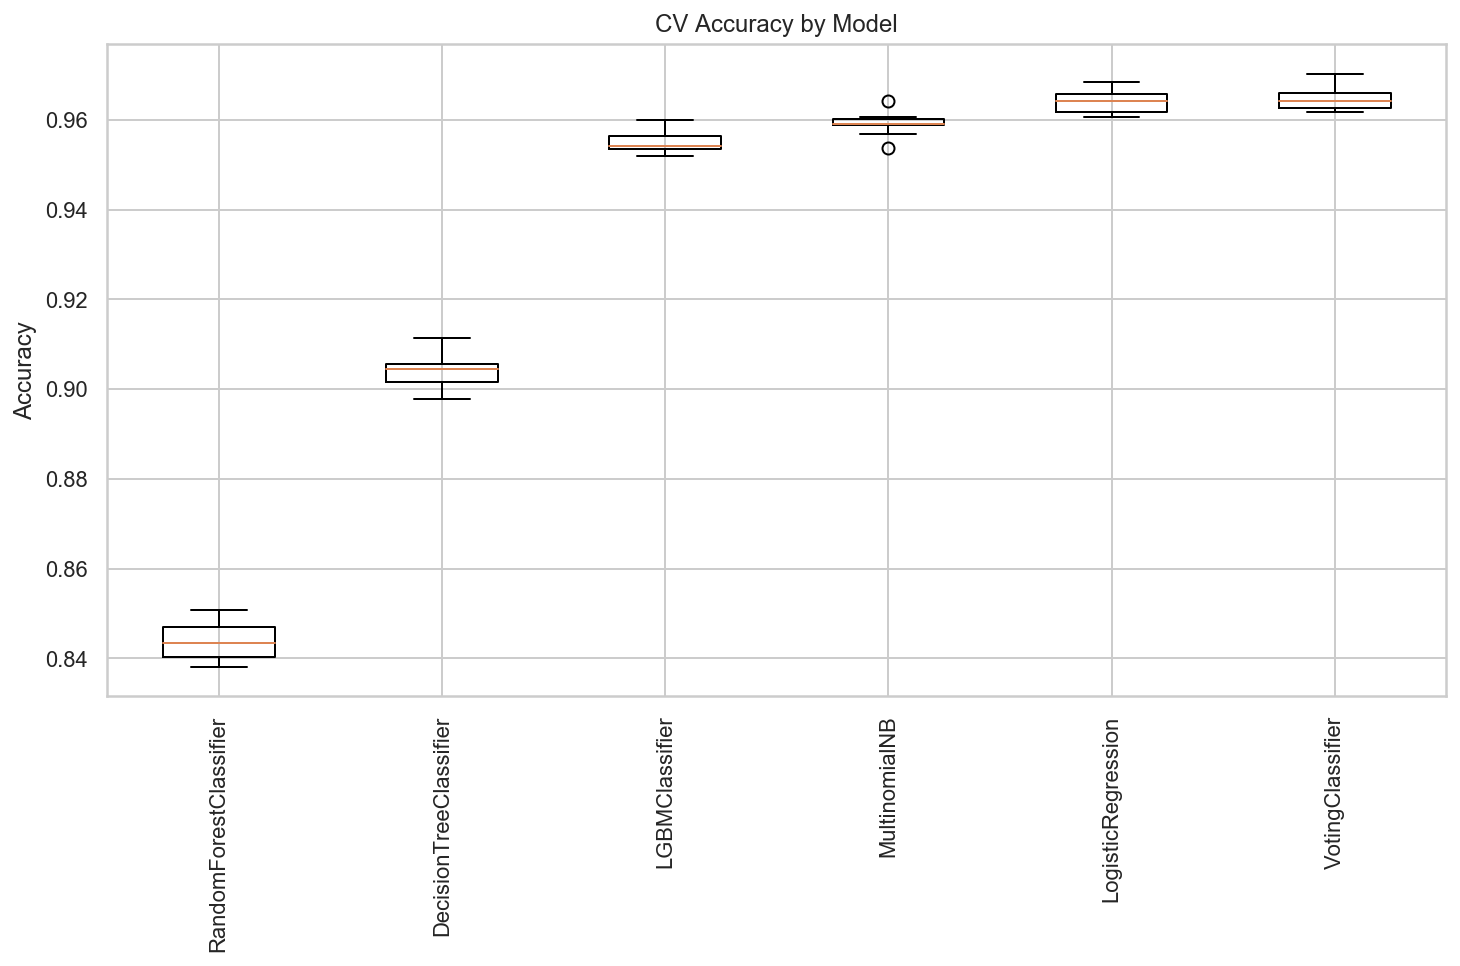

In [48]:
plt.figure(figsize=(12, 6))
plt.boxplot(data)
plt.xticks(ticks=range(1, 7), labels=labels, rotation=90)
plt.title("CV Accuracy by Model")
plt.ylabel("Accuracy")
plt.show()

## 4.2 ROC Curves & AUCs

In [14]:
plt.figure(figsize=(10, 10))

for name, model in models.items():
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
    plt.plot(fpr, tpr, label=name)


plt.title("ROC Curves")
plt.xlabel('Fallout')
plt.ylabel('Recall')
plt.legend()
plt.show()

NameError: name 'models' is not defined

<Figure size 720x720 with 0 Axes>

In [39]:
print("--- AUC ---")
for name, model in models.items():
    print("{}: ".format(name) + "%0.4f"%(roc_auc_score(y_test, 
                                                model.predict_proba(x_test)[:,1])))

--- AUC ---
MultinomialNB: 0.9789
DecisionTreeClassifier: 0.9246
RandomForestClassifier: 0.9646
LGBMClassifier: 0.9823
LogisticRegression: 0.9842
VotingClassifier: 0.9849


---

In [49]:
# TODO? hyperparameter optimization

In [13]:
param_grid = {
    "alpha": np.linspace(0, 1, 11)
}

gs = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=param_grid,
    cv=5,
    scoring="recall",
    n_jobs=N_JOBS
)

In [14]:
gs.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=6,
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [15]:
gs.best_params_

{'alpha': 0.1}

In [ ]:
param_grid = {
    "alpha": np.linspace(0, 1, 11)
}

gs = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=param_grid,
    cv=5,
    scoring="recall",
    n_jobs=N_JOBS
)